<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/RevolutPortfolioNewAssets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install yfinance

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

import requests
from bs4 import BeautifulSoup

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)

In [28]:
portfolio = ['MCD', 'T', 'PFE','FB','MSFT']
candidates = ['AAPL','ABBV','ABT','AGM','AGNC','ALB','AMTD','AMZN','APD','ARR',
              'AVAL','BABA','BAH','BEN','BLK','CAH','CATY','CBT','CCBG','CCL',
              'CFG','CL','CMA','CMCSA','COST','CSCO','CVS','CVX','D','DDS',
              'DUK','DX','EBF','EMR','ENB','EPD','EPR','FDX','FITB','FRT','GIS',
              'GOOG','GS','GWB','HBAN','IBCP','IBM','IMBBY','INTC','IRM','JNJ',
              'JPM','KEY','KMB','KO','LOW','MA','MAIN','MBWM','MCY','MDP','MDT',
              'MED','MMM','MMP','MO','MSI','MSM','NFLX','NNN','NRIM','NTAP','O',
              'OC','OKE','OZK','PEBO','PEP','PFG','PG','PLD','PM','PNC','PRU',
              'RCL','RF','SBUX','SKT','SNV','SO','SPG','STAG','STI','SWM','TGT',
              'TM','TSLA','TXN','UHT','UNH','UNM','UVV','V','VZ','WBS','WELL',
              'WEN','WFC','WMT','XOM']

assets = pd.Series(portfolio + candidates).drop_duplicates().to_list()

data = yf.download(assets, period='10y').sort_index().resample('D').last()

prices = data['Adj Close'].fillna(method="ffill")
close = data['Close'].fillna(method="ffill")

print('\nCheck for duplicates!')
print(np.sort(candidates))

[*********************100%***********************]  116 of 116 completed

Check for duplicates!
['AAPL' 'ABBV' 'ABT' 'AGM' 'AGNC' 'ALB' 'AMTD' 'AMZN' 'APD' 'ARR' 'AVAL'
 'BABA' 'BAH' 'BEN' 'BLK' 'CAH' 'CATY' 'CBT' 'CCBG' 'CCL' 'CFG' 'CL' 'CMA'
 'CMCSA' 'COST' 'CSCO' 'CVS' 'CVX' 'D' 'DDS' 'DUK' 'DX' 'EBF' 'EMR' 'ENB'
 'EPD' 'EPR' 'FDX' 'FITB' 'FRT' 'GIS' 'GOOG' 'GS' 'GWB' 'HBAN' 'IBCP'
 'IBM' 'IMBBY' 'INTC' 'IRM' 'JNJ' 'JPM' 'KEY' 'KMB' 'KO' 'LOW' 'MA' 'MAIN'
 'MBWM' 'MCY' 'MDP' 'MDT' 'MED' 'MMM' 'MMP' 'MO' 'MSI' 'MSM' 'NFLX' 'NNN'
 'NRIM' 'NTAP' 'O' 'OC' 'OKE' 'OZK' 'PEBO' 'PEP' 'PFG' 'PG' 'PLD' 'PM'
 'PNC' 'PRU' 'RCL' 'RF' 'SBUX' 'SKT' 'SNV' 'SO' 'SPG' 'STAG' 'STI' 'SWM'
 'TGT' 'TM' 'TSLA' 'TXN' 'UHT' 'UNH' 'UNM' 'UVV' 'V' 'VZ' 'WBS' 'WELL'
 'WEN' 'WFC' 'WMT' 'XOM']


In [29]:
(prices.count()[prices.count() < prices.count().quantile(0.05)]/365).sort_values()

CFG     5.241096
AVAL    5.243836
BABA    5.254795
ABBV    6.967123
FB      7.594521
STAG    8.687671
dtype: float64

In [0]:
for a in prices.count()[prices.isna().sum() > 3*365].index:
    if a not in portfolio:
        prices = prices.drop(a, axis=1)

In [53]:
def momentumBuy(close, asset='Asset', chart=False, pointVal=True):
    shortBuy = close > close.rolling(50).mean()
    mediumBuy = close > close.rolling(100).mean()
    longBuy = close > close.rolling(200).mean()

    medMBuy = close.rolling(50).mean() > close.rolling(100).mean()
    longMBuy = close.rolling(50).mean() > close.rolling(200).mean()

    veryLongBuy = close.rolling(100).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(1)),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(buySignals.columns),0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        #print(b, prob, rets.mean())

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    #print(ts.groupby('BuySignal')['Returns'].mean())
    
    for i in range(6):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)

    ts['LAG.7'] = ts['Returns'].shift(7).rolling(7).sum()
    ts['LAG.14'] = ts['Returns'].shift(14).rolling(14).sum()
    ts['LAG.28'] = ts['Returns'].shift(28).rolling(28).sum()
    ts['LAG.90'] = ts['Returns'].shift(90).rolling(90).sum()

    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][['LAG.7','LAG.14','LAG.28','LAG.90']].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        #print('\n',ss)
        #print(rets.mean(), '\n',rets.median())
        #print('\nProbabilities:')
        #print(prob.mean())
        #print(prob * hrets)
    #print(ts.groupby('Signal')['Returns'].mean())

    if pointVal:
        return ts.iloc[-1]['Signal']
    else:
        return ts

#testPrices = yf.download('CSCO')['Close']
#timeSeries = momentumBuy(testPrices, asset='CSCO')
#print(timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())
#timeSeries.tail()
momentumBuy(testPrices, asset='CSCO', pointVal=True)

'HOLD'

In [32]:
mret = prices.pct_change(28)
mret['Portfolio'] = mret[portfolio].mean(axis=1)
mret['Portfolio'].describe()

count    3623.000000
mean        0.012000
std         0.030461
min        -0.124483
25%        -0.003715
50%         0.013866
75%         0.030121
max         0.126441
Name: Portfolio, dtype: float64

In [33]:
profiles = pd.DataFrame(columns=list(['Name', 'Industry', 'Sub-Industry']), 
                        index=prices.columns, dtype=str)
profiles['Beta'] = 0.0
profiles['RET'] = mret[profiles.index].mean().mul(12)
profiles['STD'] = mret[profiles.index].std().mul(np.sqrt(12))

for a in prices.columns:
    try:
        profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
        soup = BeautifulSoup(profile_page.content, 'html.parser')

        #print(a)

        profiles.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text

        assetVariance = np.var(mret[a])
        profiles.loc[a, 'Beta'] = (np.cov(mret['Portfolio'],mret[a])/assetVariance)[0][1]

        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
    except:
        print(a)
        profiles = profiles.drop(a)
        prices = prices.drop(a, axis=1)
profiles.info()

STI
<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, AAPL to XOM
Data columns (total 6 columns):
Name            111 non-null object
Industry        111 non-null object
Sub-Industry    111 non-null object
Beta            0 non-null float64
RET             111 non-null float64
STD             111 non-null float64
dtypes: float64(3), object(3)
memory usage: 11.1+ KB


In [60]:
profiles['MoM'] = prices[profiles.index].apply(momentumBuy)
profiles.loc[portfolio]

,Name,Industry,Sub-Industry,Beta,RET,STD,LOGRET,LOGSTD,MoM
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,NaN,0.142383,0.126505,0.145212,0.155875,SELL
T,AT&T Inc.,Communication Services,Telecom Services,NaN,0.091567,0.149272,0.089428,0.167966,BUY
VTR,"Ventas, Inc.",Real Estate,REIT—Healthcare Facilities,NaN,0.077142,0.220932,0.056476,0.237517,SELL
PFE,Pfizer Inc.,Healthcare,Drug Manufacturers—General,NaN,0.114286,0.160430,0.110710,0.183102,BUY
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,NaN,0.289935,0.337909,0.168409,0.312178,BUY
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,NaN,0.188972,0.187763,0.186850,0.227046,BUY


In [0]:
ret = prices.pct_change().dropna()
wret = prices.asfreq(freq='W', method='ffill').pct_change().dropna()
wretRoll = prices.pct_change(7).dropna()

log_ret = np.log(prices.div(prices.shift(1))).fillna(0.0)
alog_ret = log_ret.rolling(365).sum()

ret['Portfolio'] = ret[portfolio].mean(axis=1)
log_ret['Portfolio'] = log_ret[portfolio].mean(axis=1).fillna(0.0)

In [35]:
#Need to add Price to Earnigns and Price to Book to profiles
profiles.loc[portfolio]

,Name,Industry,Sub-Industry,Beta,RET,STD
MCD,McDonald's Corporation,Consumer Cyclical,Restaurants,NaN,0.142383,0.126505
T,AT&T Inc.,Communication Services,Telecom Services,NaN,0.091567,0.149272
VTR,"Ventas, Inc.",Real Estate,REIT—Healthcare Facilities,NaN,0.077142,0.220932
PFE,Pfizer Inc.,Healthcare,Drug Manufacturers—General,NaN,0.114286,0.160430
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,NaN,0.289935,0.337909
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,NaN,0.188972,0.187763


In [36]:
profiles.loc[mret[mret['Portfolio'] < 0.0].corr()['Portfolio'].sort_values().head(10).index]

,Name,Industry,Sub-Industry,Beta,RET,STD
NRIM,"Northrim BanCorp, Inc.",Financial Services,Banks—Regional,NaN,0.124659,0.214660
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,NaN,0.402451,0.519972
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,NaN,0.308521,0.344083
IMBBY,Imperial Brands PLC,Consumer Defensive,Tobacco,NaN,0.066108,0.197760
NTAP,"NetApp, Inc.",Technology,Computer Hardware,NaN,0.121386,0.325734
MSI,"Motorola Solutions, Inc.",Technology,Communication Equipment,NaN,0.186859,0.191550
PEBO,Peoples Bancorp Inc.,Financial Services,Banks—Regional,NaN,0.189723,0.287054
MMP,"Magellan Midstream Partners, L.P.",Energy,Oil & Gas Midstream,NaN,0.172001,0.179380
SWM,"Schweitzer-Mauduit International, Inc.",Basic Materials,Paper & Paper Products,NaN,0.096942,0.300329
CSCO,"Cisco Systems, Inc.",Technology,Communication Equipment,NaN,0.107053,0.228903


In [37]:
portfolio_ind = profiles.loc[portfolio].groupby('Industry').count()['Name']
portfolio_subind = profiles.loc[portfolio].groupby('Sub-Industry').count()['Name']

print(portfolio_subind)
selection = profiles
industryCount = len(profiles.groupby('Industry').count().index)
subIndustryCount = len(profiles.groupby('Sub-Industry').count().index)

port_Ind_fully_invested = len(portfolio_ind.index) == industryCount
port_subInd_fully_invested = len(portfolio_subind.index) == subIndustryCount

for i in portfolio_ind.index:
    if port_Ind_fully_invested:
        if portfolio_ind.loc[i] == portfolio_ind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Industry'] != i]
for i in portfolio_subind.index:
    if port_subInd_fully_invested:
        if portfolio_subind.loc[i] == portfolio_subind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Sub-Industry'] != i]

selection.sort_values(by=['Industry', 'Sub-Industry','Beta'])

Sub-Industry
Drug Manufacturers—General        1
Internet Content & Information    1
REIT—Healthcare Facilities        1
Restaurants                       1
Software—Infrastructure           1
Telecom Services                  1
Name: Name, dtype: int64


,Name,Industry,Sub-Industry,Beta,RET,STD
APD,"Air Products and Chemicals, Inc.",Basic Materials,Chemicals,NaN,0.146963,0.179118
SWM,"Schweitzer-Mauduit International, Inc.",Basic Materials,Paper & Paper Products,NaN,0.096942,0.300329
ALB,Albemarle Corporation,Basic Materials,Specialty Chemicals,NaN,0.108573,0.289401
CBT,Cabot Corporation,Basic Materials,Specialty Chemicals,NaN,0.116055,0.291182
KO,The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,NaN,0.102390,0.120777
...,...,...,...,...,...,...
EMR,Emerson Electric Co.,Industrials,Specialty Industrial Machinery,NaN,0.101463,0.210249
MMM,3M Company,Industrials,Specialty Industrial Machinery,NaN,0.105124,0.171492
D,"Dominion Energy, Inc.",Utilities,Utilities—Diversified,NaN,0.114952,0.130546
DUK,Duke Energy Corporation,Utilities,Utilities—Regulated Electric,NaN,0.095603,0.132675


In [38]:
profiles.loc[['AMZN','TSLA','IBM','CSCO']]

,Name,Industry,Sub-Industry,Beta,RET,STD
AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,NaN,0.278548,0.273092
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,NaN,0.402451,0.519972
IBM,International Business Machines Corporation,Technology,Information Technology Services,NaN,0.046999,0.177815
CSCO,"Cisco Systems, Inc.",Technology,Communication Equipment,NaN,0.107053,0.228903


In [39]:
val = prices[selection.index].iloc[-1]/prices[selection.index].iloc[-365:].mean()
val = val[val < 1.0]
underVal = []

for a in val.index.to_list():
    if np.logical_and(prices[a].iloc[-3*365:].pct_change().mean() > 0.0,
                      a not in portfolio):
        underVal.append(a)

print('Currently assets under consideration:\n{}'.format(underVal))

Currently assets under consideration:
['MCY', 'MMM']


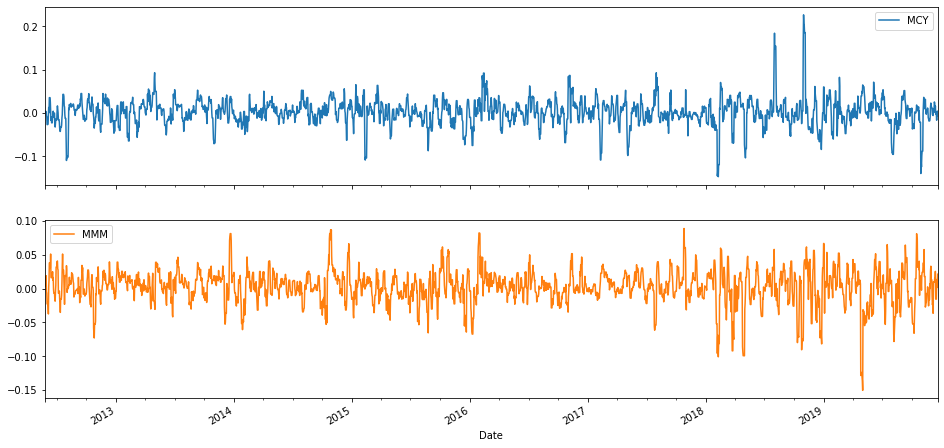

,MCY,MMM
count,2765.000000,2765.000000
mean,0.090458,0.134906
std,1.620685,1.314068
min,-7.678486,-7.835125
25%,-0.671620,-0.432459
50%,0.143282,0.199022
75%,0.891153,0.863228
max,11.796395,4.624184


In [40]:
wretRoll[underVal].plot(subplots=True, figsize=(16,8))
plt.show();

wretRoll[underVal].mul(52).describe()

Lowest correlating assets:
                              Name            Industry  ...       RET       STD
DDS                Dillard's, Inc.   Consumer Cyclical  ...  0.203996  0.394513
IBCP  Independent Bank Corporation  Financial Services  ...  0.298444  0.662447
MED                 Medifast, Inc.   Consumer Cyclical  ...  0.204026  0.434087
NRIM        Northrim BanCorp, Inc.  Financial Services  ...  0.124659  0.214660
TGT             Target Corporation  Consumer Defensive  ...  0.140622  0.234186
UVV          Universal Corporation  Consumer Defensive  ...  0.086528  0.263433

[6 rows x 6 columns]


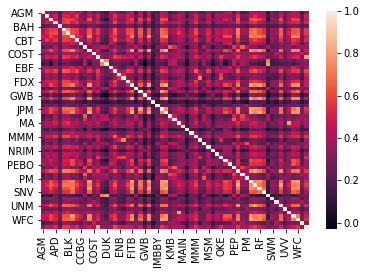

In [41]:
selAss = selection.index.to_list()
low_corr = ret.corr()[ret.corr()['Portfolio'] <= ret.corr()['Portfolio'].quantile(0.05)]
print('Lowest correlating assets:\n{}'.format(profiles.loc[low_corr.index]))

sns.heatmap(log_ret.corr().loc[selAss, selAss])
plt.show()

In [42]:
sel = selection.index.to_list()[:]
sel.append('Portfolio')

sel_corr = ret[sel].corr()['Portfolio']
print(sel_corr.sort_values().head(10))

diversifiedPicks = sel_corr.sort_values()[sel_corr<sel_corr.quantile(0.25)].index.to_list()

IBCP    0.218531
UVV     0.247573
NRIM    0.263692
TGT     0.264624
GWB     0.272110
AGM     0.287341
EBF     0.290039
SWM     0.290320
CCBG    0.296993
MBWM    0.304239
Name: Portfolio, dtype: float64


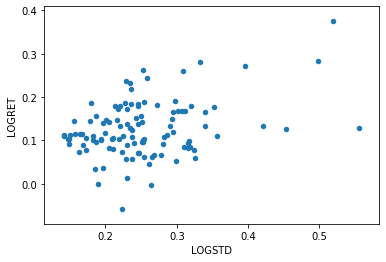

In [43]:
profiles['LOGRET'] = log_ret.mean().mul(365)
profiles['LOGSTD'] = log_ret.std().mul(np.sqrt(365))

profiles.plot(kind='scatter', x='LOGSTD', y='LOGRET')#, size='Beta')
plt.show()

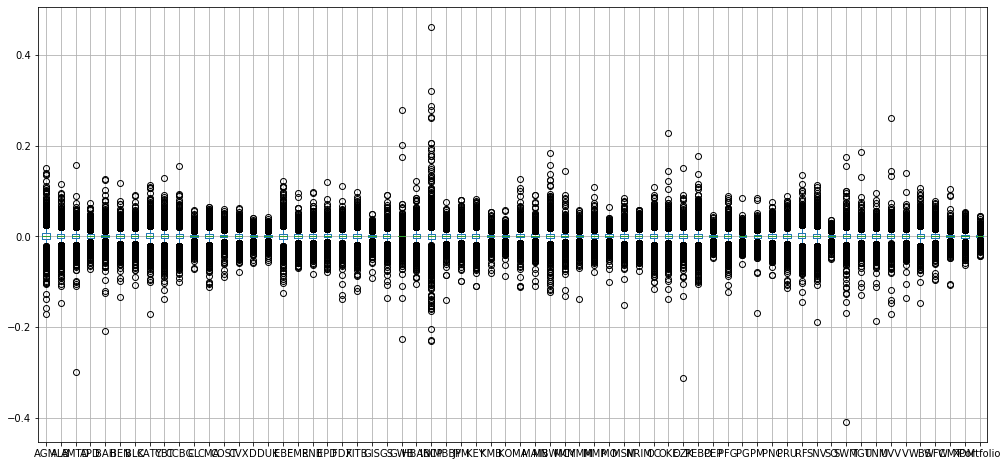

AGM: 14.7%, 14.42%, 1.02
ALB: 11.98%, 14.08%, 0.85
AMTD: 12.52%, 13.86%, 0.9
APD: 12.86%, 13.29%, 0.97
BAH: 13.5%, 13.05%, 1.03
BEN: 10.76%, 13.95%, 0.77
BLK: 12.26%, 13.9%, 0.88
CATY: 13.39%, 14.21%, 0.94
CBT: 12.02%, 14.12%, 0.85
CCBG: 12.16%, 13.72%, 0.89
CL: 11.86%, 12.74%, 0.93
CMA: 12.37%, 13.72%, 0.9
COST: 13.46%, 12.87%, 1.05
CVX: 11.95%, 13.25%, 0.9
D: 12.45%, 12.62%, 0.99
DUK: 12.14%, 12.48%, 0.97
EBF: 12.03%, 13.92%, 0.86
EMR: 12.1%, 13.49%, 0.9
ENB: 12.38%, 13.09%, 0.95
EPD: 12.8%, 12.99%, 0.99
FDX: 11.71%, 13.65%, 0.86
FITB: 12.74%, 13.9%, 0.92
GIS: 11.93%, 12.61%, 0.95
GS: 11.48%, 13.69%, 0.84
GWB: 12.21%, 12.59%, 0.97
HBAN: 13.18%, 13.91%, 0.95
IBCP: 12.64%, 15.0%, 0.84
IMBBY: 11.64%, 12.98%, 0.9
JPM: 12.86%, 13.69%, 0.94
KEY: 12.94%, 13.93%, 0.93
KMB: 12.45%, 12.7%, 0.98
KO: 12.28%, 12.65%, 0.97
MA: 14.56%, 13.82%, 1.05
MAIN: 13.37%, 13.02%, 1.03
MBWM: 14.82%, 13.17%, 1.13
MCY: 11.88%, 13.09%, 0.91
MMM: 12.25%, 13.2%, 0.93
MMP: 13.27%, 12.77%, 1.04
MO: 12.89%, 12.77%, 1

In [44]:
log_ret[sel].boxplot(figsize=(17,8))
plt.show()

candidatesSeries = pd.Series(index=sel)
riskSeries = pd.Series(index=sel)
for n in sel:
    t = portfolio[:]
    t.append(n)
    
    mu = log_ret[t].mean(axis=1).mean()*365
    cov = log_ret[t].cov()
    w = np.ones(len(t))
    w /= np.sum(w)
    risk = np.sqrt(365 * np.dot(w.T, np.dot(cov, w)))

    riskSeries.loc[n] = risk
    candidatesSeries.loc[n] = mu/risk
    print('{}: {}%, {}%, {}'.format(n, round(100*mu,2), 
                                    round(100*risk,2), 
                                    round(mu/risk, 2)))

bestSH = candidatesSeries[candidatesSeries > candidatesSeries['Portfolio']]
bestSH = bestSH[bestSH > bestSH.quantile(0.75)].index.to_list()

lowestRisk = riskSeries[riskSeries < riskSeries['Portfolio']]
lowestRisk = lowestRisk[lowestRisk < lowestRisk.quantile(0.25)].index.to_list()

print('\nBased on Return/Risk ratio, best pick would be {}'.format(bestSH))
print('Based on lowest portfolio Risk, best pick would be {}'.format(lowestRisk))

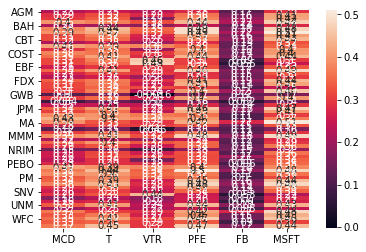

GWB     0.160477
IBCP    0.177370
MBWM    0.188047
NRIM    0.209773
MMP     0.255877
EPD     0.282121
AGM     0.292476
PEBO    0.309874
BAH     0.312308
OZK     0.315471
dtype: float64

Based on correlations, best picks would be:
['GWB', 'IBCP', 'MBWM', 'NRIM', 'MMP', 'EPD', 'AGM', 'PEBO', 'BAH', 'OZK', 'IMBBY', 'CCBG', 'SWM', 'UVV', 'SNV', 'TGT']


In [45]:
sns.heatmap(log_ret.corr(method='pearson').loc[selection.index, portfolio], annot=True)
plt.show()

bestPick = pd.Series(data=np.zeros(len(selection.index)), index=selection.index)

for b in bestPick.index:
    pear = pearsonr(log_ret['Portfolio'], log_ret[b])
    spear = spearmanr(log_ret['Portfolio'], log_ret[b])

    pSum = pear[1]+spear[1]
    if np.logical_and(pear[1]<0.05, spear[1]<0.05):
        bestPick.loc[b] = pear[0]*pear[1]/pSum + spear[0]*spear[1]/pSum
    elif pear[1]<0.05:
        bestPick.loc[b] = pear[0]
    elif spear[1]<0.05:
        bestPick.loc[b] = spear[0]

bestPick = bestPick.dropna()
bestCOR = bestPick[bestPick < bestPick.quantile(0.25)].sort_values().index.to_list()

print(bestPick.sort_values().head(10))
print('\nBased on correlations, best picks would be:\n{}'.format(bestCOR))

In [46]:
n = 100
simRet = pd.DataFrame(columns=sel, index=list(range(n)))
simRisk = pd.DataFrame(columns=sel, index=list(range(n)))

for asset in sel:
    simRet[asset] = 0.0
    simRisk[asset] = 0.0

    for i in range(n):
        mu = ret[asset].mean()
        sigma = ret[asset].std()
        
        simulations = (np.ones(n*365) * mu -(sigma**2)/2) + np.random.standard_normal(n*365) * sigma
        
        simRet.loc[i, asset] = np.mean(simulations) * 365
        simRisk.loc[i, asset] = np.std(simulations) * np.sqrt(365)


bestRisk = simRisk.mode().median().sort_values()
bestRisk = bestRisk[bestRisk < bestRisk.quantile(0.25)]

bestReturns = simRet.mode().median()
bestReturns = bestReturns[bestReturns>bestReturns.quantile(0.75)]

bestSharpe = bestReturns/bestRisk
bestSharpe = bestSharpe[bestSharpe > bestSharpe.quantile(0.75)].sort_values(ascending=False)

if 'Portfolio' in bestSharpe.index: bestSharpe = bestSharpe.drop('Portfolio')
if 'Portfolio' in bestRisk.index: bestRisk = bestRisk.drop('Portfolio')
if 'Portfolio' in bestReturns.index: bestReturns = bestReturns.drop('Portfolio')

bestReturns.sort_values(ascending=False)

BAH     0.282461
IBCP    0.279973
MA      0.275981
V       0.262984
JPM     0.211172
CCBG    0.210102
COST    0.196045
APD     0.183379
AGM     0.179001
BLK     0.168815
AMTD    0.165620
MAIN    0.165342
MBWM    0.161956
KEY     0.158227
RF      0.155618
dtype: float64

In [47]:
invetable = []

if len(bestSH)>=1:
    #print('\nBased on Return/Risk ratio, best picks would be:')
    for p in bestSH:
        #print(p)
        invetable.append(p)

if len(lowestRisk)>=1:
    #print('\nBased on Risk, best picks would be:')
    for p in lowestRisk:
        #print(p)
        invetable.append(p)

if len(bestCOR)>=1:
    #print('\nBased on correlations, best picks would be:')
    for p in bestCOR:
        #print(p)
        invetable.append(p)

if len(underVal)>=1:
    #print('\nBased on historical prices these stocks seam undervalued:')
    for p in underVal:
        #print(p)
        invetable.append(p)

try:
    if len(bestSharpe.index)>=1:
        #print('\nBased on simulated Return/Risk ratio, best picks would be:')        
        for p in bestSharpe.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestRisk.index):
        #print('\nBased on simulated Risk, best picks would be:')        
        for p in bestRisk.index.to_list():
            #print(p)
            invetable.append(p)

    if len(bestReturns.index)>=1:
        #print('\nBased on simulated Return, best picks would be:')        
        for p in bestReturns.index.to_list():
            #print(p)
            invetable.append(p)
except:
    print('\nNo simulations were made.')
    
invDF = pd.DataFrame(invetable).groupby(0)[0].count()
print('\nMost frequently picked assets:')
profiles.loc[invDF.sort_values(ascending=False)[invDF==invDF.max()].index]


Most frequently picked assets:


,Name,Industry,Sub-Industry,Beta,RET,STD,LOGRET,LOGSTD
0,,,,,,,,
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,NaN,0.225515,0.244411,0.188104,0.253917
COST,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,NaN,0.186447,0.160729,0.185329,0.179451
MBWM,Mercantile Bank Corporation,Financial Services,Banks—Regional,NaN,0.308521,0.344083,0.280606,0.332967


In [48]:
selection[selection['Beta'] <= selection['Beta'].quantile(0.25)].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Beta,RET,STD


In [49]:
profiles[profiles['Beta'] <= profiles['Beta'].quantile(0.05)].sort_values(by='Beta')

,Name,Industry,Sub-Industry,Beta,RET,STD,LOGRET,LOGSTD
